In [513]:
import torch
torch.cuda.is_available()

True

In [514]:
# imports
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [515]:

#from google.colab import drive
#drive.mount('/content/drive')

#device = 'cpu'
device=torch.device("cuda")

In [516]:
# Clearing Cuda cach
import gc

gc.collect()

torch.cuda.empty_cache()

In [517]:
def get_data():
    #data_dir = '/content/drive/MyDrive/classified'
    data_dir = 'C:/Users/bl/Documents/CNNcomp472/classified'
    
    
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256,256)),
                                    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]) 

    
    original_set = datasets.ImageFolder(root=data_dir, transform=transform)  # dataset

    print(original_set.classes)
    n = len(original_set)  # total number of examples
    n_test= int(0.25*n)# take ~25% for test
    for x in range(0, 9): # rounding it to be divisible by 4
      n_test+=1
      if n_test % 4 == 0: 
        break 

    # test_set = torch.utils.data.Subset(original_set, range(n_test))  # take first 25%
    # train_set = torch.utils.data.Subset(original_set, range(n_test, n))  # take the rest


    train_set, test_set = torch.utils.data.random_split(original_set, [n-n_test, n_test])

    train = DataLoader(train_set, batch_size=32, shuffle=True)
    test = DataLoader(test_set, batch_size=int(len(test_set)/4), shuffle=False)

    print(len(train_set))
    print(len(test_set))
    print(n)
    

    return train, test, train_set, test_set, original_set

In [518]:
train, test, train_set, test_set, original_set = get_data()

['cloth_mask', 'n95_mask', 'no_mask', 'surgical_mask']
1201
404
1605


In [519]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
        )

                
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1),
        )
        
        self.fc_layer1 = nn.Sequential(
            nn.Linear(32 * 32 * 128, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
        )

        self.fc_layer2 = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
        )

        self.fc_layerFinal = nn.Sequential(
            nn.Linear(1000, 4),
        )
        
    def forward(self, x):
        # conv layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layers
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layerFinal(x)
        return x


In [520]:
num_epochs = 25
num_classes = 4
learning_rate = 0.001

model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/25], Loss: 1.6621, Accuracy: 35.29%
Epoch [2/25], Loss: 1.2232, Accuracy: 41.18%
Epoch [3/25], Loss: 1.1161, Accuracy: 58.82%
Epoch [4/25], Loss: 1.0707, Accuracy: 47.06%
Epoch [5/25], Loss: 1.1563, Accuracy: 52.94%
Epoch [6/25], Loss: 1.0235, Accuracy: 58.82%
Epoch [7/25], Loss: 0.8739, Accuracy: 76.47%
Epoch [8/25], Loss: 1.0121, Accuracy: 58.82%
Epoch [9/25], Loss: 1.2380, Accuracy: 41.18%
Epoch [10/25], Loss: 0.9031, Accuracy: 64.71%
Epoch [11/25], Loss: 0.6001, Accuracy: 82.35%
Epoch [12/25], Loss: 0.4328, Accuracy: 94.12%
Epoch [13/25], Loss: 0.5594, Accuracy: 76.47%
Epoch [14/25], Loss: 0.6133, Accuracy: 76.47%
Epoch [15/25], Loss: 0.6667, Accuracy: 82.35%
Epoch [16/25], Loss: 0.5885, Accuracy: 88.24%
Epoch [17/25], Loss: 0.2563, Accuracy: 94.12%
Epoch [18/25], Loss: 0.4644, Accuracy: 82.35%
Epoch [19/25], Loss: 0.9032, Accuracy: 76.47%
Epoch [20/25], Loss: 0.3043, Accuracy: 88.24%
Epoch [21/25], Loss: 0.0908, Accuracy: 94.12%
Epoch [22/25], Loss: 0.1046, Accuracy: 100.

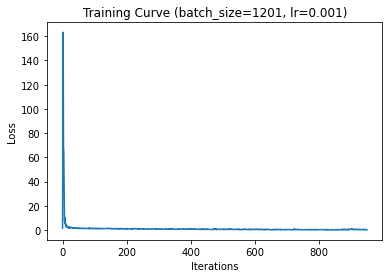

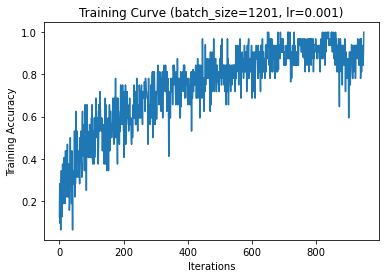

In [521]:
# print accuracies at each step

total_step = len(train)
loss_list = []
acc_list = []
iterations=[]

n=0
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train):
    # Move them to device (cuda or cpu)
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())
    # Backprop and optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Train accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    #
    iterations.append(n)
    n+=1
    
  print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        .format(epoch + 1, num_epochs, loss.item(),
        (correct / total) * 100))
  
# plotting
plt.plot(iterations, loss_list)
plt.title("Training Curve (batch_size={}, lr={})".format(len(train_set), learning_rate))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
plt.plot(iterations, acc_list)
plt.title("Training Curve (batch_size={}, lr={})".format(len(train_set), learning_rate))
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.show()  


In [522]:
# Saving the trained model and emptying the GPU memory
torch.save(model.state_dict(), 'C:/Users/bl/Desktop/cnnModelSaves/model.pth')
#del model
torch.cuda.empty_cache()

In [523]:
#Loading the model before testing
model = CNN()
model.load_state_dict(torch.load('C:/Users/bl/Desktop/cnnModelSaves/model.pth'))
model = model.to(device)

In [524]:
# overall accuracy 
with torch.no_grad():
    correct = 0
    total = 0
    for pred_images, pred_labels in test:
        pred_images = pred_images.to(device)
        pred_labels = pred_labels.to(device)
        pred_outputs = model(pred_images)
        _, pred_predicted = torch.max(pred_outputs.data, 1)
        total += pred_labels.size(0)
        correct += (pred_predicted == pred_labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(len(test.dataset), (correct / total)*100 ))

Accuracy of the network on the 404 train images: 45.54455445544555 %


In [525]:
# print tensors

classes = original_set.classes
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print("Predicted: ",predicted, len(predicted))
        print("Expected: ",labels,len(labels))
        total += labels.size(0)

Predicted:  tensor([1, 3, 0, 3, 3, 3, 2, 3, 1, 0, 2, 0, 3, 0, 3, 1, 0, 1, 3, 0, 2, 3, 2, 0,
        2, 1, 3, 2, 3, 1, 2, 1, 2, 1, 2, 1, 0, 3, 1, 3, 2, 2, 3, 0, 2, 2, 1, 1,
        2, 1, 2, 1, 0, 1, 2, 2, 3, 2, 3, 0, 3, 3, 3, 2, 3, 1, 0, 0, 0, 2, 1, 0,
        1, 2, 1, 2, 2, 1, 1, 0, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2,
        0, 1, 0, 3, 0], device='cuda:0') 101
Expected:  tensor([3, 0, 0, 1, 3, 3, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 3, 1, 2, 2,
        2, 2, 3, 2, 1, 3, 0, 1, 0, 2, 2, 2, 0, 2, 1, 3, 2, 1, 1, 0, 2, 0, 2, 3,
        2, 0, 0, 3, 0, 3, 0, 2, 3, 2, 3, 2, 3, 3, 1, 2, 3, 2, 0, 2, 0, 1, 1, 0,
        3, 2, 1, 2, 0, 1, 1, 3, 3, 1, 0, 3, 0, 1, 2, 0, 0, 3, 1, 0, 2, 3, 2, 2,
        0, 1, 0, 3, 0], device='cuda:0') 101
Predicted:  tensor([3, 0, 1, 3, 1, 0, 2, 3, 2, 1, 1, 0, 2, 2, 2, 1, 3, 2, 1, 0, 3, 0, 1, 1,
        1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 3, 3, 0, 1, 1, 1, 0, 1, 1, 3, 3, 3,
        2, 3, 3, 2, 2, 0, 2, 0, 2, 1, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 1, 0, 0

In [526]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report

eval_labels = pred_labels.detach().cpu()
eval_predictions = pred_predicted.detach().cpu()


print(classification_report(eval_labels, eval_predictions))

              precision    recall  f1-score   support

           0       0.39      0.48      0.43        25
           1       0.44      0.52      0.48        29
           2       0.41      0.28      0.33        25
           3       0.32      0.27      0.29        22

    accuracy                           0.40       101
   macro avg       0.39      0.39      0.38       101
weighted avg       0.39      0.40      0.39       101



<Figure size 6400x4800 with 0 Axes>

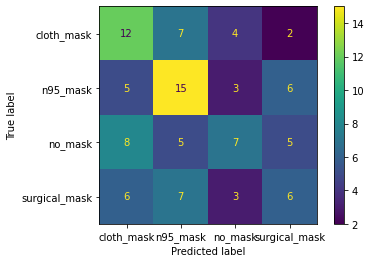

In [527]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure

figure(figsize=(80, 60), dpi=80)
cm = confusion_matrix(eval_labels, eval_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=original_set.classes)
disp.plot()

plt.show()